# Prototype

In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import pandas
import seaborn as sns 
from sklearn import preprocessing
import nltk 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
import re
import string
import matplotlib.cm as cm
from matplotlib import rcParams
from prettytable import PrettyTable
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
pd.options.display.float_format = "{:.2f}".format

In [3]:
cols = ['class','tweet_text']
positive = pd.read_csv('Arabic_tweets_positive.tsv',sep='\t', error_bad_lines = False ,header=None, names=cols)
positive.head()

,class,tweet_text
0,pos,هه خلي فضولش ف جيبش 🌚
1,pos,موجود ماسافرت 😊
2,pos,: مسابقة #43 #متابعي_شامخ فقط# 🔘السحب على200💰ر...
3,pos,اللهم امين 🌺
4,pos,يعني اذا ما احبج احب منو؟ 💘


In [4]:
print("positive tweets: ",len(positive))

positive tweets:  76094


In [5]:
positive['tweet_text'].head()

0                                هه خلي فضولش ف جيبش 🌚
1                                      موجود ماسافرت 😊
2    : مسابقة #43 #متابعي_شامخ فقط# 🔘السحب على200💰ر...
3                                         اللهم امين 🌺
4                          يعني اذا ما احبج احب منو؟ 💘
Name: tweet_text, dtype: object

In [6]:
positive['class'].head()

0    pos
1    pos
2    pos
3    pos
4    pos
Name: class, dtype: object

In [7]:
positive[positive.isnull().any(axis=1)].head()
np.sum(positive.isnull().any(axis=1))

0

In [8]:
positive.isnull().any(axis=0)

class         False
tweet_text    False
dtype: bool

In [64]:
positive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76094 entries, 0 to 76093
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class       76094 non-null  object
 1   tweet_text  76094 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [65]:
for letter in '#.][!XR':
    positive['tweet_text'] = positive['tweet_text'].astype(str).str.replace(letter,'')

In [66]:
positive.head()

,class,tweet_text
0,pos,هه خلي فضولش ف جيبش 🌚
1,pos,موجود ماسافرت 😊
2,pos,: مسابقة 43 متابعي_شامخ فقط 🔘السحب على200💰ريال...
3,pos,اللهم امين 🌺
4,pos,يعني اذا ما احبج احب منو؟ 💘


In [67]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [68]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [71]:
#def remove_repeating_char(text):
   # return re.sub(r'(.)\1+', r'\1', text)

In [72]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [73]:
def processPost(tweet): 

    #Replace @username with empty string
    tweet = re.sub('@[^\s]+', ' ', tweet)
    
    #Convert www.* or https?://* to " "
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)

    # remove punctuations
    tweet= remove_punctuations(tweet)
    
    # normalize the tweet
    tweet= normalize_arabic(tweet)
    
    # remove repeated letters
    #tweet=remove_repeating_char(tweet)

    # remove emoji
    tweet=remove_emoji(tweet)
    
    return tweet

In [74]:
positive["tweet_text"] = positive['tweet_text'].apply(lambda x: processPost(x))

In [75]:
positive.tweet_text.values

array(['هه خلي فضولش ف جيبش ', 'موجود ماسافرت ',
       ' مسابقه 43 متابعيشامخ فقط السحب علي200ريال الشروط  متابعه  رتويت التغريده  رتويت المثبته بحسابه دعما له',
       ...,
       ' ازعل وازعل وارجوك لا تسال زيد الزعل وازعل وانا لك علي اراضيك ',
       ' هل تقبلين ان تكوني ابنتي للابد ',
       '    في عيوني انت اجمل من علي الدنيا لقيت رضيت فيك صحبه اهل  واحباب رضيت فيك حياه وعمر   مساءالخير   جي'],
      dtype=object)

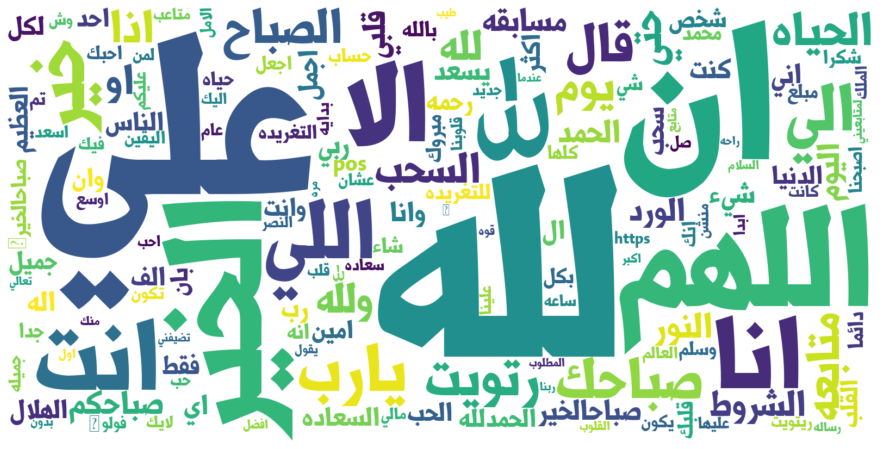

In [76]:
from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display
from nltk.corpus import stopwords
from itertools import islice


text = " ".join(line for line in positive['tweet_text'])
stop_ar = stopwords.words('arabic') 
# add more stop words here like numbers, special characters, etc. It should be customized for your project

top_words = {}
words = text.split()
for w in words:
    if w in stop_ar:
        continue
    else:
        if w not in top_words:
            top_words[w] = 1
        else:
            top_words[w] +=1

# Sort the dictionary of the most frequent words
top_words = {k: v for k, v in sorted(top_words.items(), key=lambda item: item[1], reverse = True)}

# select the first 150 most frequent words
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
for_wc = take(150, top_words.items())

# you need to reshape your words to be shown properly and turn the result into a dictionary
dic_data = {}
for t in for_wc:
    r = arabic_reshaper.reshape(t[0]) # connect Arabic letters
    bdt = get_display(r) # right to left
    dic_data[bdt] = t[1] 

# Plot
wc = WordCloud(background_color="white", width=1600, height=800,max_words=400 ,font_path='Shoroq-Font.ttf').generate_from_frequencies(dic_data)
plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


In [53]:
import os
import codecs
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import arabic_reshaper
from bidi.algorithm import get_display
text = positive.tweet_text
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

TypeError: expected string or bytes-like object

In [77]:
tokenizer = RegexpTokenizer(r'\w+')
positive["tweet_text"] = positive["tweet_text"].apply(tokenizer.tokenize)

In [78]:
positive["tweet_text"].head()

0                            [هه, خلي, فضولش, ف, جيبش]
1                                     [موجود, ماسافرت]
2    [مسابقه, 43, متابعيشامخ, فقط, السحب, علي200ريا...
3                                        [اللهم, امين]
4                      [يعني, اذا, ما, احبج, احب, منو]
Name: tweet_text, dtype: object

In [79]:
stopwords_list = stopwords.words('arabic')
stopwords_list

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [80]:
print(len(stopwords_list))

754


In [81]:
listToStr = ' '.join([str(elem) for elem in stopwords_list])
listToStr

'إذ إذا إذما إذن أف أقل أكثر ألا إلا التي الذي الذين اللاتي اللائي اللتان اللتيا اللتين اللذان اللذين اللواتي إلى إليك إليكم إليكما إليكن أم أما أما إما أن إن إنا أنا أنت أنتم أنتما أنتن إنما إنه أنى أنى آه آها أو أولاء أولئك أوه آي أي أيها إي أين أين أينما إيه بخ بس بعد بعض بك بكم بكم بكما بكن بل بلى بما بماذا بمن بنا به بها بهم بهما بهن بي بين بيد تلك تلكم تلكما ته تي تين تينك ثم ثمة حاشا حبذا حتى حيث حيثما حين خلا دون ذا ذات ذاك ذان ذانك ذلك ذلكم ذلكما ذلكن ذه ذو ذوا ذواتا ذواتي ذي ذين ذينك ريث سوف سوى شتان عدا عسى عل على عليك عليه عما عن عند غير فإذا فإن فلا فمن في فيم فيما فيه فيها قد كأن كأنما كأي كأين كذا كذلك كل كلا كلاهما كلتا كلما كليكما كليهما كم كم كما كي كيت كيف كيفما لا لاسيما لدى لست لستم لستما لستن لسن لسنا لعل لك لكم لكما لكن لكنما لكي لكيلا لم لما لن لنا له لها لهم لهما لهن لو لولا لوما لي لئن ليت ليس ليسا ليست ليستا ليسوا ما ماذا متى مذ مع مما ممن من منه منها منذ مه مهما نحن نحو نعم ها هاتان هاته هاتي هاتين هاك هاهنا هذا هذان هذه هذي هذين هكذا هل هلا هم هما هن هنا هن

In [82]:
positive["tweet_text"]=positive["tweet_text"].apply(lambda x: [item for item in x if item not in stopwords_list])

In [83]:
all_words = [word for tokens in positive["tweet_text"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in positive["tweet_text"]]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

709484 words total, with a vocabulary size of 71018
Max sentence length is 792


In [84]:
#wordcloud
counter = Counter(all_words)
counter.most_common(25)

[('الله', 13547),
 ('علي', 9477),
 ('ان', 6680),
 ('اللهم', 5688),
 ('الخير', 5435),
 ('الا', 3396),
 ('انا', 2679),
 ('انت', 2609),
 ('اللي', 2578),
 ('خير', 2183),
 ('يارب', 2171),
 ('الي', 2134),
 ('صباحك', 1994),
 ('رتويت', 1815),
 ('قال', 1779),
 ('الصباح', 1767),
 ('يوم', 1650),
 ('الحياه', 1644),
 ('متابعه', 1633),
 ('اذا', 1561),
 ('السحب', 1557),
 ('والله', 1487),
 ('لله', 1466),
 ('او', 1461),
 ('الشروط', 1416)]

In [85]:
counted_words = Counter(all_words)

words = []
counts = []
for letter, count in counted_words.most_common(25):
    words.append(letter)
    counts.append(count)

<BarContainer object of 25 artists>

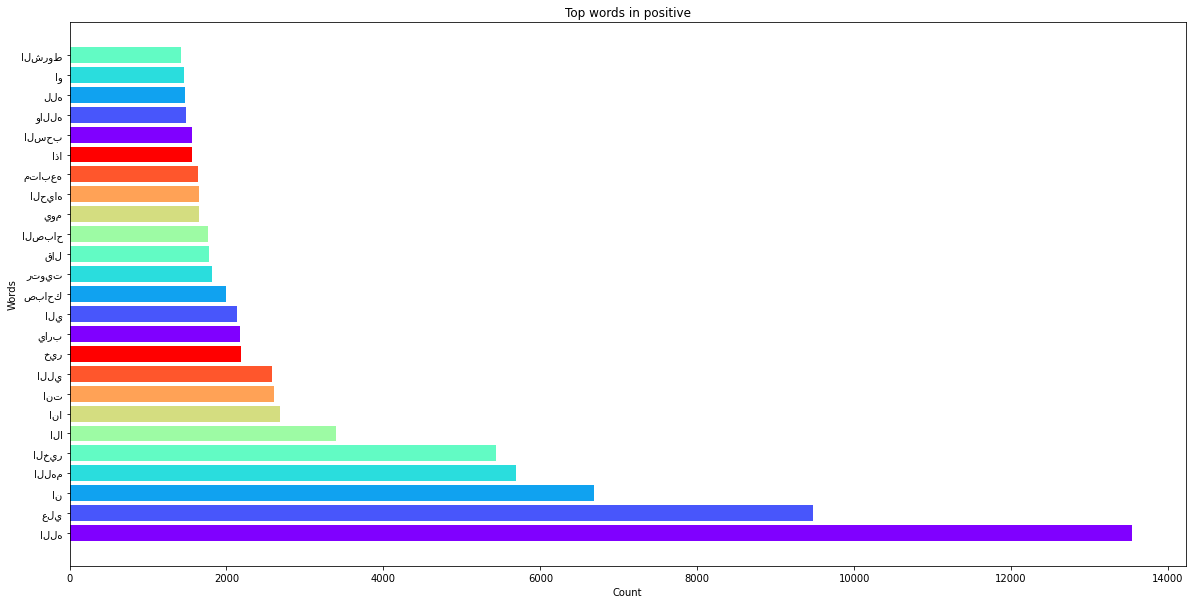

In [86]:
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in positive')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

In [87]:
cols = ['class','tweet_text']
negative = pd.read_csv('Arabic_tweets_negative.tsv',sep='\t', error_bad_lines = False ,header=None, names=cols)
negative.head()

,class,tweet_text
0,neg,انمي Family Guy الموسم الحلقة السادسة مترجمة H...
1,neg,صدااع من الغباء لي ساعه افكر وش اقول بس غبائها...
2,neg,قتيلا وجريحا… حصيلة تفرقة المتظاهرين في كربلاء...
3,neg,اللهم من أصلح شأنهم وجمع كلمتهم ووحد صفهم ياقا...
4,neg,كوميديا.. الذهبية تذهب بالخطأ لصاحبة المركز ال...


In [88]:
print("Negative tweets: ",len(negative))

Negative tweets:  72234


In [89]:
negative['class'].head()

0    neg
1    neg
2    neg
3    neg
4    neg
Name: class, dtype: object

In [90]:
negative[negative.isnull().any(axis=1)].head()
np.sum(negative.isnull().any(axis=1))

0

In [91]:
negative.isnull().any(axis=0)
negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72234 entries, 0 to 72233
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class       72234 non-null  object
 1   tweet_text  72234 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [92]:
for letter in '#.][!XR':
    negative['tweet_text'] = negative['tweet_text'].astype(str).str.replace(letter,'')

In [93]:
negative.head()

,class,tweet_text
0,neg,انمي Family Guy الموسم الحلقة السادسة مترجمة H...
1,neg,صدااع من الغباء لي ساعه افكر وش اقول بس غبائها...
2,neg,قتيلا وجريحا… حصيلة تفرقة المتظاهرين في كربلاء...
3,neg,اللهم من أصلح شأنهم وجمع كلمتهم ووحد صفهم ياقا...
4,neg,كوميديا الذهبية تذهب بالخطأ لصاحبة المركز الثا...


In [94]:
negative["tweet_text"] = negative['tweet_text'].apply(lambda x: processPost(x))

In [95]:
tokenizer = RegexpTokenizer(r'\w+')
negative["tweet_text"] = negative["tweet_text"].apply(tokenizer.tokenize)
negative["tweet_text"].head()

0    [انمي, Family, Guy, الموسم, الحلقه, السادسه, م...
1    [صدااع, من, الغباء, لي, ساعه, افكر, وش, اقول, ...
2    [قتيلا, وجريحا, حصيله, تفرقه, المتظاهرين, في, ...
3    [اللهم, من, اصلح, شانهم, وجمع, كلمتهم, ووحد, ص...
4    [كوميديا, الذهبيه, تذهب, بالخطا, لصاحبه, المرك...
Name: tweet_text, dtype: object

In [96]:
negative["tweet_text"]=negative["tweet_text"].apply(lambda x: [item for item in x if item not in stopwords_list])

In [97]:
all_words = [word for tokens in negative["tweet_text"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in negative["tweet_text"]]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

669482 words total, with a vocabulary size of 77275
Max sentence length is 1161


In [98]:
counter = Counter(all_words)
counter.most_common(25)

[('علي', 11270),
 ('الله', 8562),
 ('ان', 4741),
 ('انا', 4372),
 ('والله', 2736),
 ('الي', 2537),
 ('قال', 2498),
 ('اللي', 2350),
 ('الا', 1726),
 ('امي', 1674),
 ('قلبي', 1674),
 ('اي', 1661),
 ('وهي', 1656),
 ('يارب', 1600),
 ('يوم', 1503),
 ('التلفزيون', 1491),
 ('كنت', 1470),
 ('الناس', 1463),
 ('ريتويت', 1452),
 ('دخلت', 1431),
 ('يعني', 1415),
 ('ابحث', 1391),
 ('شي', 1382),
 ('الاول', 1372),
 ('اللهم', 1369)]

In [99]:
counted_words = Counter(all_words)

words = []
counts = []
for letter, count in counted_words.most_common(25):
    words.append(letter)
    counts.append(count)

<BarContainer object of 25 artists>

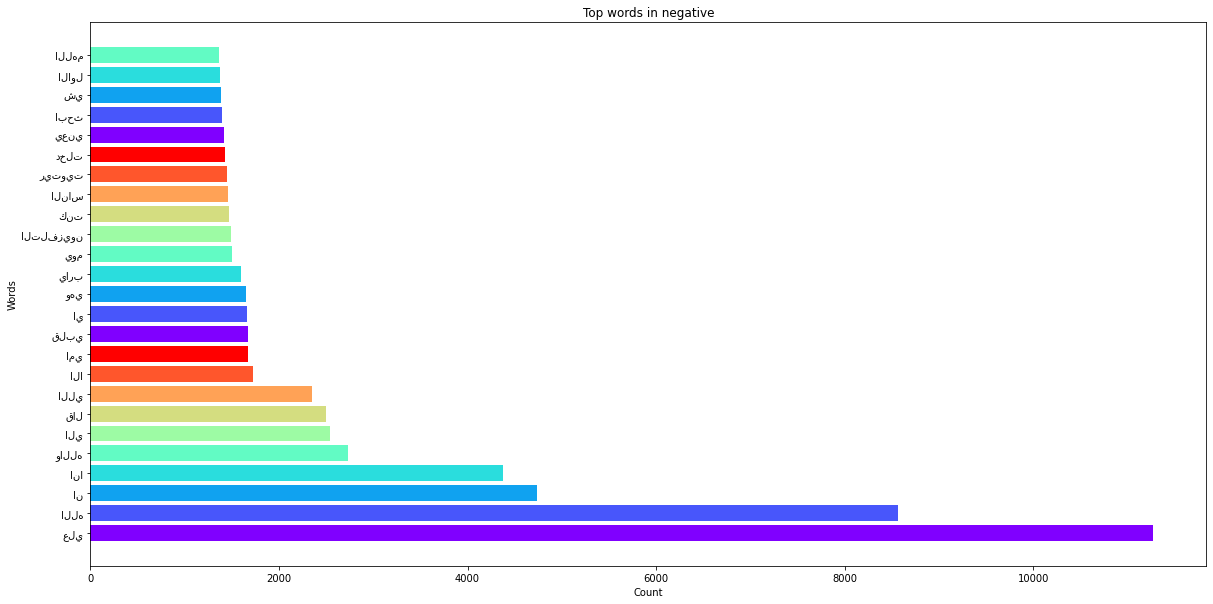

In [100]:
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in negative')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

In [101]:
final_data = pd.concat([positive, negative], axis=0)
# اضف shuffle

In [102]:
final_data.sample(5)

,class,tweet_text
36103,pos,"[روحي, سيدي, بن, فاطمه]"
10449,neg,"[متي, تجاهد, البارحه, ولايه, سيناء, ولايه, الب..."
72155,pos,"[مهرجان, للقراءه, تشاهدونه, صور, عفويه, لثوار,..."
35560,neg,"[انا, والله, منا, نيرد, حاجه, بكتب, التكاليف, ..."
66825,neg,"[دقيقه, تبدئي, ربع, ساعه, واجي]"


In [103]:
print(len(final_data))

148328


In [104]:
y=final_data['class']
y.value_counts()

pos    76094
neg    72234
Name: class, dtype: int64

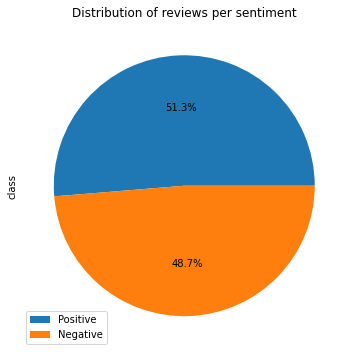

In [105]:
final_data['class'].value_counts().plot.pie(figsize=(6,6),title="Distribution of reviews per sentiment",labels=['',''],autopct='%1.1f%%' )
labels=["Positive","Negative"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')


In [ ]:
# احسب المصطلجات الفريت

In [106]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    max_features =10000)

unigramdataGet= word_vectorizer.fit_transform(final_data['tweet_text'].astype('str'))
unigramdataGet = unigramdataGet.toarray()

vocab = word_vectorizer.get_feature_names()
unigramdata_features=pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)
unigramdata_features[unigramdata_features>0] = 1

unigramdata_features.head()

,00,10,100,100ريال,10k,112019,115,119,1200,14,...,٣٠,٥٢,ٱل,ٱلله,ٱللہ,ٲلبال,کنت,ڪريم,ڪل,ۆالسرۆر
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [107]:
pro= preprocessing.LabelEncoder()
encpro=pro.fit_transform(final_data['class'])
final_data['class'] = encpro

In [108]:
y=final_data['class']
X=unigramdata_features

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

In [114]:
y_test.value_counts()

1    15140
0    14526
Name: class, dtype: int64

In [115]:
y_train.value_counts()



1    60954
0    57708
Name: class, dtype: int64

In [116]:
print("Train Size: ", len(X_train))
print("Test Size:  ", len(X_test))

Train Size:  118662
Test Size:   29666


In [117]:
#ensemble model python code
nb=GaussianNB()
nb= nb.fit(X_train , y_train)
nb

GaussianNB()

In [122]:

y_pred = nb.predict(X_test)
nb_1=nb.score(X_test, y_test)
print('Accuracy= {:.3f}'.format(nb.score(X_test, y_test)))

Accuracy= 0.756


In [123]:
print('Precision',round(precision_score(y_test, y_pred),2),'%')

Precision 0.86 %


In [124]:
print('Recall',round(recall_score(y_test, y_pred),2),'%')

Recall 0.62 %


In [125]:
rf_f1=round(f1_score(y_test, y_pred),2)
print('F1',round(f1_score(y_test, y_pred),2),'%')

F1 0.72 %


In [126]:
RC= RidgeClassifier()
RC= RC.fit(X_train , y_train)
RC

RidgeClassifier()

In [118]:
y_pred = RC.predict(X_test)
rc_1=RC.score(X_test, y_test)
print('Accuracy= {:.3f}'.format(RC.score(X_test, y_test)))

Accuracy= 0.823


In [119]:
print('Precision',round(precision_score(y_test, y_pred),2),'%')

Precision 0.84 %


In [120]:
print('Recall',round(recall_score(y_test, y_pred),2),'%')

Recall 0.8 %


In [121]:
rf_f1=round(f1_score(y_test, y_pred),2)
print('F1',round(f1_score(y_test, y_pred),2),'%')

F1 0.82 %


In [122]:
LR= LogisticRegression(penalty = 'l2', C = 1)
LR= LR.fit(X_train , y_train)
LR

LogisticRegression(C=1)

In [123]:
y_pred = LR.predict(X_test)
lr_1=LR.score(X_test, y_test)
print('Accuracy= {:.3f}'.format(LR.score(X_test, y_test)))

Accuracy= 0.829


In [124]:
print('Precision',round(precision_score(y_test, y_pred),2),'%')

Precision 0.85 %


In [125]:
print('Recall',round(recall_score(y_test, y_pred),2),'%')

Recall 0.8 %


In [1]:
rf_f1=round(f1_score(y_test, y_pred),2)
print('F1',round(f1_score(y_test, y_pred),2),'%')

NameError: name 'f1_score' is not defined

In [127]:
from sklearn import svm
svm1 = svm.SVC(kernel='linear')
svm1.fit(X_train, y_train)
svm1

In [103]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=10)
clf= clf.fit(X_train , y_train)
clf

RandomForestClassifier(n_estimators=10)

In [104]:
y_pred = clf.predict(X_test)
clf_1=clf.score(X_test, y_test)
print('Accuracy= {:.3f}'.format(clf.score(X_test, y_test)))

Accuracy= 0.841


In [105]:
x = PrettyTable()
print('\n')
print("Comparison of all algorithms on F1 score")
x.field_names = ["Model", "F1"]


x.add_row(["Naive Bayes Algorithm", round(nb_1,2)])
x.add_row(["Ridge Classifier Algorithm",  round(rc_1,2)])
x.add_row(["Logistic Regression Algorithm", round(lr_1,2)])
x.add_row(["Random Forest Algorithm", round(clf_1,2)])

print(x)
print('\n')



Comparison of all algorithms on F1 score
+-------------------------------+------+
|             Model             |  F1  |
+-------------------------------+------+
|     Naive Bayes Algorithm     | 0.75 |
|   Ridge Classifier Algorithm  | 0.82 |
| Logistic Regression Algorithm | 0.83 |
|    Random Forest Algorithm    | 0.84 |
+-------------------------------+------+




In [121]:
tv=['  انا اليوم سعيد جدا عشان الهلال فاز ']
tv2=['اقسم بالله لو تجيب طاري الهلال على لسانك لا اقصه لك ']

In [122]:
pred=clf.predict(word_vectorizer.transform(tv))
pred=pro.inverse_transform(pred)
prediction=pd.DataFrame(pred, columns=['Prediction']) 
print (tv,prediction)

['  انا اليوم سعيد جدا عشان الهلال فاز ']   Prediction
0        pos


In [123]:
pred=clf.predict(word_vectorizer.transform(tv2))
pred=pro.inverse_transform(pred)
prediction=pd.DataFrame(pred, columns=['Prediction']) 
print (tv2,prediction)

['اقسم بالله لو تجيب طاري الهلال على لسانك لا اقصه لك ']   Prediction
0        neg


In [124]:
target_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.82      0.86      0.84     14526
    Positive       0.86      0.82      0.84     15140

    accuracy                           0.84     29666
   macro avg       0.84      0.84      0.84     29666
weighted avg       0.84      0.84      0.84     29666



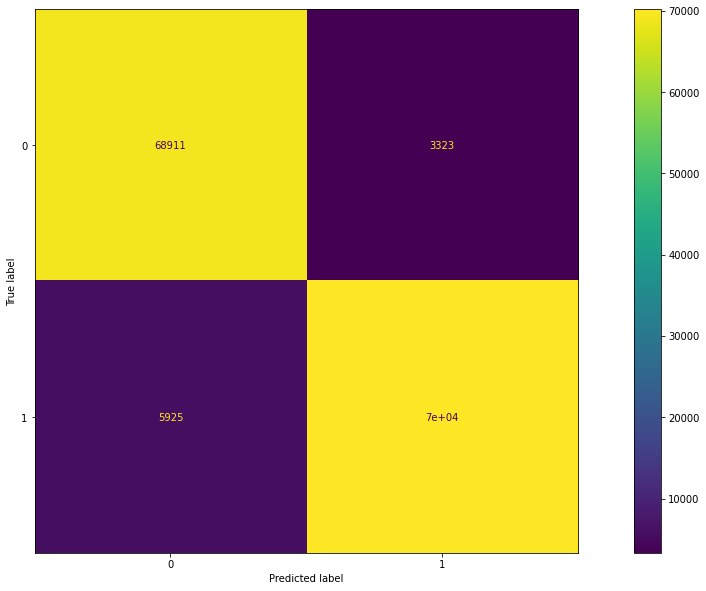

In [127]:
##LR = LogisticRegression(penalty = 'l2', C = 1)
##LR.fit(X_train , y_train) # fit your classifier

# make predictions with your classifier
y_pred = clf.predict(X)         
# optional: get true negative (tn), false positive (fp)
# false negative (fn) and true positive (tp) from confusion matrix
M = confusion_matrix(y, y_pred)
tn, fp, fn, tp = M.ravel() 
# plotting the confusion matrix
plot_confusion_matrix(clf, X, y)
plt.show()

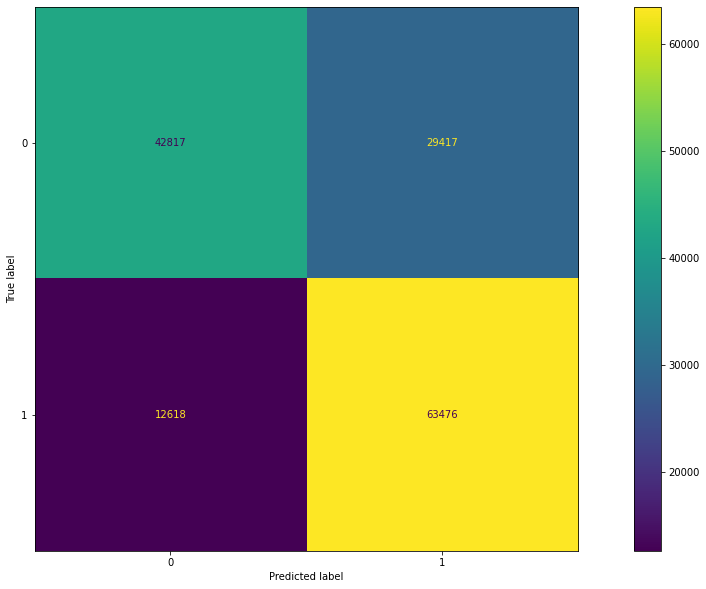

In [73]:
nb = nb=GaussianNB()
nb.fit(X_train , y_train) # fit your classifier

# make predictions with your classifier
y_pred = nb.predict(X)         
# optional: get true negative (tn), false positive (fp)
# false negative (fn) and true positive (tp) from confusion matrix
M = confusion_matrix(y, y_pred)
tn, fp, fn, tp = M.ravel() 
# plotting the confusion matrix
plot_confusion_matrix(nb, X, y)
plt.show()

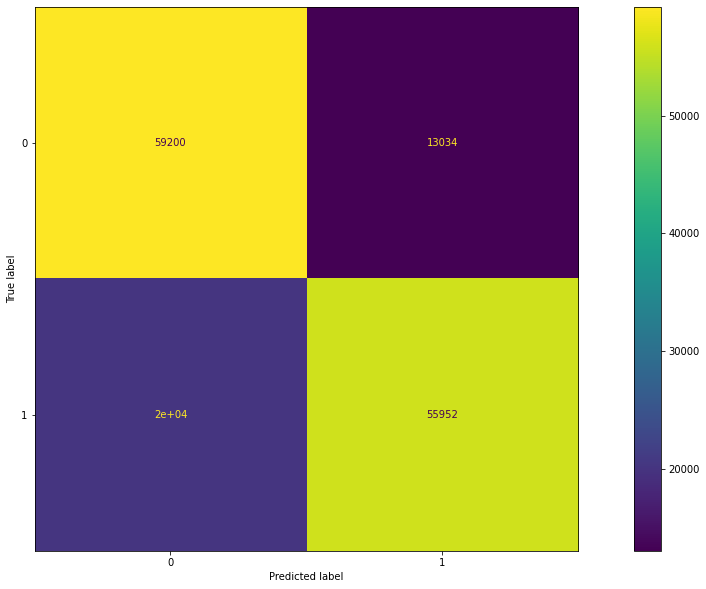

In [74]:
RC= RidgeClassifier()
RC.fit(X_train , y_train) # fit your classifier

# make predictions with your classifier
y_pred = RC.predict(X)         
# optional: get true negative (tn), false positive (fp)
# false negative (fn) and true positive (tp) from confusion matrix
M = confusion_matrix(y, y_pred)
tn, fp, fn, tp = M.ravel() 
# plotting the confusion matrix
plot_confusion_matrix(RC, X, y)
plt.show()